In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import yfinance as yf

data = yf.download(tickers = "GC=F", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1274.099976,1288.599976,1271.000000,1278.800049,1278.800049,823
2017-12-04,1272.500000,1276.099976,1270.300049,1274.300049,1274.300049,850
2017-12-05,1275.400024,1275.800049,1260.000000,1261.599976,1261.599976,1499
2017-12-06,1264.900024,1267.800049,1261.599976,1262.800049,1262.800049,373
2017-12-07,1262.300049,1262.400024,1243.900024,1249.800049,1249.800049,358
...,...,...,...,...,...,...
2023-06-09,1965.099976,1969.800049,1960.300049,1962.199951,1962.199951,49
2023-06-12,1959.699951,1963.500000,1951.400024,1955.300049,1955.300049,212
2023-06-13,1960.599976,1967.500000,1940.300049,1944.599976,1944.599976,343


In [3]:
data = data.reset_index('Date', inplace=False)

In [4]:
# Chuyển cột 'Date' thành kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp dữ liệu theo thứ tự tăng dần của cột 'Date'
data.sort_values(by='Date', inplace=True)

# Chuyển cột 'Date' thành mảng numpy
dates = data['Date'].values

# Chuyển cột 'Close' thành mảng numpy
close_prices = data['Close'].values

In [5]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [6]:
train_dates = train_data['Date'].values
train_close_prices = train_data['Close'].values
val_dates = val_data['Date'].values
val_close_prices = val_data['Close'].values
test_dates = test_data['Date'].values
test_close_prices = test_data['Close'].values

In [7]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values

In [8]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [9]:
# Xác định kiến trúc của mạng Bayesian Neural Network
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# Xác định hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [11]:
# Khởi tạo mô hình BNN
model = BNN(input_size=1, output_size=1)

In [12]:
# Huấn luyện mô hình BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/1000], Loss: 731961.8125
Epoch [200/1000], Loss: 1535213.875
Epoch [300/1000], Loss: 1044804.3125
Epoch [400/1000], Loss: 994919.3125
Epoch [500/1000], Loss: 385730.65625
Epoch [600/1000], Loss: 623815.625
Epoch [700/1000], Loss: 943813.75
Epoch [800/1000], Loss: 727115.0
Epoch [900/1000], Loss: 820416.0
Epoch [1000/1000], Loss: 357821.0


In [13]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [14]:
# Dự đoán trên tập validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [15]:
# In kết quả dự đoán trên tập test
print('Kết quả dự đoán trên tập test:')
for i in range(len(test_dates)):
    print(f'Date: {test_dates[i]}, Predicted Close: {y_pred_test[i].item()}')

Kết quả dự đoán trên tập test:
Date: 975, Predicted Close: 2732.880615234375
Date: 976, Predicted Close: 2735.671875
Date: 977, Predicted Close: 2738.462890625
Date: 978, Predicted Close: 2741.25390625
Date: 979, Predicted Close: 2744.044921875
Date: 980, Predicted Close: 2746.8359375
Date: 981, Predicted Close: 2749.626953125
Date: 982, Predicted Close: 2752.41796875
Date: 983, Predicted Close: 2755.208740234375
Date: 984, Predicted Close: 2758.0
Date: 985, Predicted Close: 2760.790771484375
Date: 986, Predicted Close: 2763.581787109375
Date: 987, Predicted Close: 2766.372802734375
Date: 988, Predicted Close: 2769.16357421875
Date: 989, Predicted Close: 2771.954833984375
Date: 990, Predicted Close: 2774.745849609375
Date: 991, Predicted Close: 2777.536865234375
Date: 992, Predicted Close: 2780.32763671875
Date: 993, Predicted Close: 2783.118896484375
Date: 994, Predicted Close: 2785.90966796875
Date: 995, Predicted Close: 2788.70068359375
Date: 996, Predicted Close: 2791.49169921875
D

In [16]:
# In kết quả dự đoán trên tập validation
print('Kết quả dự đoán trên tập validation:')
for i in range(len(val_dates)):
    print(f'Date: {val_dates[i]}, Predicted Close: {y_pred_val[i].item()}')


Kết quả dự đoán trên tập validation:
Date: 1253, Predicted Close: 3508.775634765625
Date: 1254, Predicted Close: 3511.566650390625
Date: 1255, Predicted Close: 3514.357421875
Date: 1256, Predicted Close: 3517.14892578125
Date: 1257, Predicted Close: 3519.939697265625
Date: 1258, Predicted Close: 3522.730712890625
Date: 1259, Predicted Close: 3525.521484375
Date: 1260, Predicted Close: 3528.312744140625
Date: 1261, Predicted Close: 3531.103759765625
Date: 1262, Predicted Close: 3533.89501953125
Date: 1263, Predicted Close: 3536.685546875
Date: 1264, Predicted Close: 3539.47705078125
Date: 1265, Predicted Close: 3542.267822265625
Date: 1266, Predicted Close: 3545.05908203125
Date: 1267, Predicted Close: 3547.849853515625
Date: 1268, Predicted Close: 3550.640869140625
Date: 1269, Predicted Close: 3553.431884765625
Date: 1270, Predicted Close: 3556.22265625
Date: 1271, Predicted Close: 3559.013671875
Date: 1272, Predicted Close: 3561.804931640625
Date: 1273, Predicted Close: 3564.595458984

In [17]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
#x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()
# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'Date: {x_next_30_days[i]}, Predicted Close: {y_pred_next[i]}')

Date: tensor([1394.]), Predicted Close: 3902.305908203125
Date: tensor([1395.]), Predicted Close: 3905.096435546875
Date: tensor([1396.]), Predicted Close: 3907.886962890625
Date: tensor([1397.]), Predicted Close: 3910.678466796875
Date: tensor([1398.]), Predicted Close: 3913.46923828125
Date: tensor([1399.]), Predicted Close: 3916.260498046875
Date: tensor([1400.]), Predicted Close: 3919.05126953125
Date: tensor([1401.]), Predicted Close: 3921.842529296875
Date: tensor([1402.]), Predicted Close: 3924.633544921875
Date: tensor([1403.]), Predicted Close: 3927.42431640625
Date: tensor([1404.]), Predicted Close: 3930.21533203125
Date: tensor([1405.]), Predicted Close: 3933.00634765625
Date: tensor([1406.]), Predicted Close: 3935.79736328125
Date: tensor([1407.]), Predicted Close: 3938.58837890625
Date: tensor([1408.]), Predicted Close: 3941.379150390625
Date: tensor([1409.]), Predicted Close: 3944.170166015625
Date: tensor([1410.]), Predicted Close: 3946.96142578125
Date: tensor([1411.]),

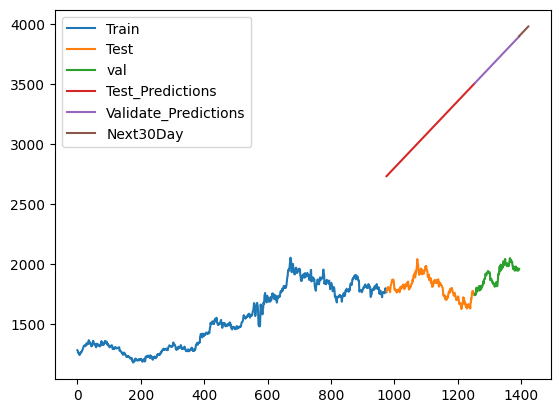

In [18]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()